In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import lightgbm as lgb

In [2]:
train_new = pd.read_csv('data/train_added_encoded.csv')
test_new = pd.read_csv('data/test_added_encoded.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [3]:
train_new.head(13)

,id,goal,country,duration,category1,category2,html_content,state,goal_min,goal_max
0,0,4001-5000,4,28,12,142,"<div class=""contents""><div><span class=""bold"">...",0,4001.0,5000.0
1,1,3001-4000,16,33,5,108,"<div class=""contents""><div><h1 class=""page-anc...",0,3001.0,4000.0
2,2,19001-20000,21,29,7,122,"<div class=""contents""><div><p> As our society ...",0,19001.0,20000.0
3,3,2001-3000,21,40,13,0,"<div class=""contents""><div><p>My name is Donal...",0,2001.0,3000.0
4,4,2001-3000,9,28,13,33,"<div class=""contents""><div><div class=""templat...",1,2001.0,3000.0
5,5,1-1000,21,18,11,49,"<div class=""contents""><div><h1 class=""page-anc...",1,1.0,1000.0
6,6,3001-4000,9,58,5,7,"<div class=""contents""><div><p>We are raising f...",0,3001.0,4000.0
7,7,1-1000,21,19,0,77,"<div class=""contents""><div><p>Hello world,</p>...",1,1.0,1000.0
8,8,2001-3000,21,27,12,89,"<div class=""contents""><div><p>You are cool wit...",1,2001.0,3000.0
9,9,1001-2000,9,20,6,34,"<div class=""contents""><div><h1 class=""page-anc...",1,1001.0,2000.0


In [4]:
def run_lgbm(test, train, target_cols, feature_cols, categorical_cols):
    X_train = train[feature_cols]
    y_train = train[target_cols]
    X_test = test[feature_cols]
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train.loc[train_index]
        y_val = y_train.loc[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=10,
                          num_boost_round=1000,
                          early_stopping_rounds=10)


        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        # display importance
        importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
        display(importance)

    return oof_train, sum(y_preds) / len(y_preds)

In [5]:
target_cols = ["state"]
feature_cols = ["country", "duration", "category1", "category2", "goal_min", "goal_max"]
categorical_cols = ["country", "category1", "category2"]
params = {
        'num_leaves': 24,
        'max_depth': 5,
        'objective': 'binary',
        'learning_rate': 0.01
    }

In [6]:
# run lgbm
oof = train_new.copy()
sub = sub.copy()
_oof, _preds = run_lgbm(test_new, train_new, target_cols, feature_cols, categorical_cols)

/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4244, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503082 -> initscore=0.012328
[LightGBM] [Info] Start training from score 0.012328
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.660996	valid_1's binary_logloss: 0.662492
[20]	training's binary_logloss: 0.634115	valid_1's binary_logloss: 0.636921
[30]	training's binary_logloss: 0.61134	valid_1's binary_logloss: 0.615193
[40]	training's binary_logloss: 0.591928	valid_1's binary_logloss: 0.596909
[50]	training's binary_logloss: 0.575064	valid_1's binary_logloss: 0.581174
[60]	t

,importance
country,263
duration,3555
category1,161
category2,1851
goal_min,3361
goal_max,10


/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4236, number of negative: 4200
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502134 -> initscore=0.008535
[LightGBM] [Info] Start training from score 0.008535
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.660186	valid_1's binary_logloss: 0.663096
[20]	training's binary_logloss: 0.632625	valid_1's binary_logloss: 0.638577
[30]	training's binary_logloss: 0.609579	valid_1's binary_logloss: 0.618413
[40]	training's binary_logloss: 0.590085	valid_1's binary_logloss: 0.601589
[50]	training's binary_logloss: 0.573193	valid_1's binary_logloss: 0.587111
[60]	training's binary_logloss: 0.558435	valid_1's binary_logloss: 0.

,importance
country,218
duration,3383
category1,120
category2,1831
goal_min,2894
goal_max,58


/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4250, number of negative: 4186
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503793 -> initscore=0.015173
[LightGBM] [Info] Start training from score 0.015173
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.660555	valid_1's binary_logloss: 0.662634
[20]	training's binary_logloss: 0.63349	valid_1's binary_logloss: 0.637711
[30]	training's binary_logloss: 0.610631	valid_1's binary_logloss: 0.616666
[40]	training's binary_logloss: 0.591049	valid_1's binary_logloss: 0.598493
[50]	training's binary_logloss: 0.574209	valid_1's binary_logloss: 0.582981
[60]	t

,importance
country,412
duration,4105
category1,184
category2,2410
goal_min,4100
goal_max,4


/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4268, number of negative: 4168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505927 -> initscore=0.023709
[LightGBM] [Info] Start training from score 0.023709
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.660714	valid_1's binary_logloss: 0.662335
[20]	training's binary_logloss: 0.633767	valid_1's binary_logloss: 0.636716
[30]	training's binary_logloss: 0.611388	valid_1's binary_logloss: 0.615641
[40]	training's binary_logloss: 0.592027	valid_1's binary_logloss: 0.597641
[50]	training's binary_logloss: 0.575298	valid_1's binary_logloss: 0.582073
[60]	training's binary_logloss: 0.560735	valid_1's binary_logloss: 0.

,importance
country,251
duration,3387
category1,97
category2,1938
goal_min,3177
goal_max,25


/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Applications/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4274, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 8436, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506638 -> initscore=0.026554
[LightGBM] [Info] Start training from score 0.026554
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.66145	valid_1's binary_logloss: 0.661919
[20]	training's binary_logloss: 0.635128	valid_1's binary_logloss: 0.635776
[30]	training's binary_logloss: 0.61271	valid_1's binary_logloss: 0.61358
[40]	training's binary_logloss: 0.593489	valid_1's binary_logloss: 0.594591
[50]	training's binary_logloss: 0.576831	valid_1's binary_logloss: 0.578121
[60]	training's binary_logloss: 0.562428	valid_1's binary_logloss: 0.563

,importance
country,509
duration,4261
category1,190
category2,2425
goal_min,4204
goal_max,10


In [106]:
_oof

array([0.22061622, 0.26649386, 0.55510086, ..., 0.10187641, 0.9888219 ,
       0.11422737])

In [107]:
def check_oof_score(oof, y_train, threshold):
    oof = np.where(oof<threshold, 0, 1)
    f1score = f1_score(y_true=y_train, y_pred=oof,average='binary', sample_weight=None, zero_division='warn')
    return f1score

In [124]:
def optimize_threshold(oof, y_train):
    best_score = 0
    for thr in np.arange(0, 1.0, 0.05):
        oof_ = np.where(oof<thr, 0, 1)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    return best_score, best_threshold

In [125]:
best_score, best_threshold = optimize_threshold(_oof, list(train_new["state"]))
print(best_score, best_threshold)

0.7556987115956394 0.35000000000000003


In [116]:
_preds

array([0.65021481, 0.34260467, 0.96313919, ..., 0.78482009, 0.34271588,
       0.18570584])

In [117]:
sub

,10545,0
0,10546,1
1,10547,0
2,10548,0
3,10549,0
4,10550,1
...,...,...
10538,21084,0
10539,21085,1
10540,21086,1
10541,21087,1


In [118]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

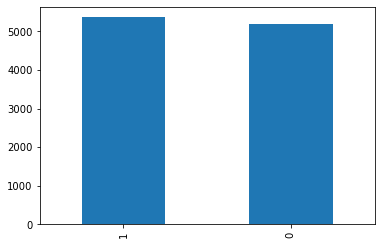

In [130]:
sub_file = making_sub(_preds, 0.45)
sub_file.to_csv(f"sub_files/lgbm_sub_{8}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")

In [ ]:
# TO DO: 
# カテゴリー名をword2vecで数値にして学習(カテゴリカル変数で無くする)
# threshold tuningの方法をどうするか　（1，0の分布が確からしいかで最適化 or oofのスコアで最適化）